<a href="https://colab.research.google.com/github/rohitrrk22/Brain_Tumor_Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dish Classification

## Import necessary Libraries 

In [1]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=b879899719386211df63c1de92c4ddb9ac4e23e017f96748e2cf929331e7789b
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

## Data Visualization

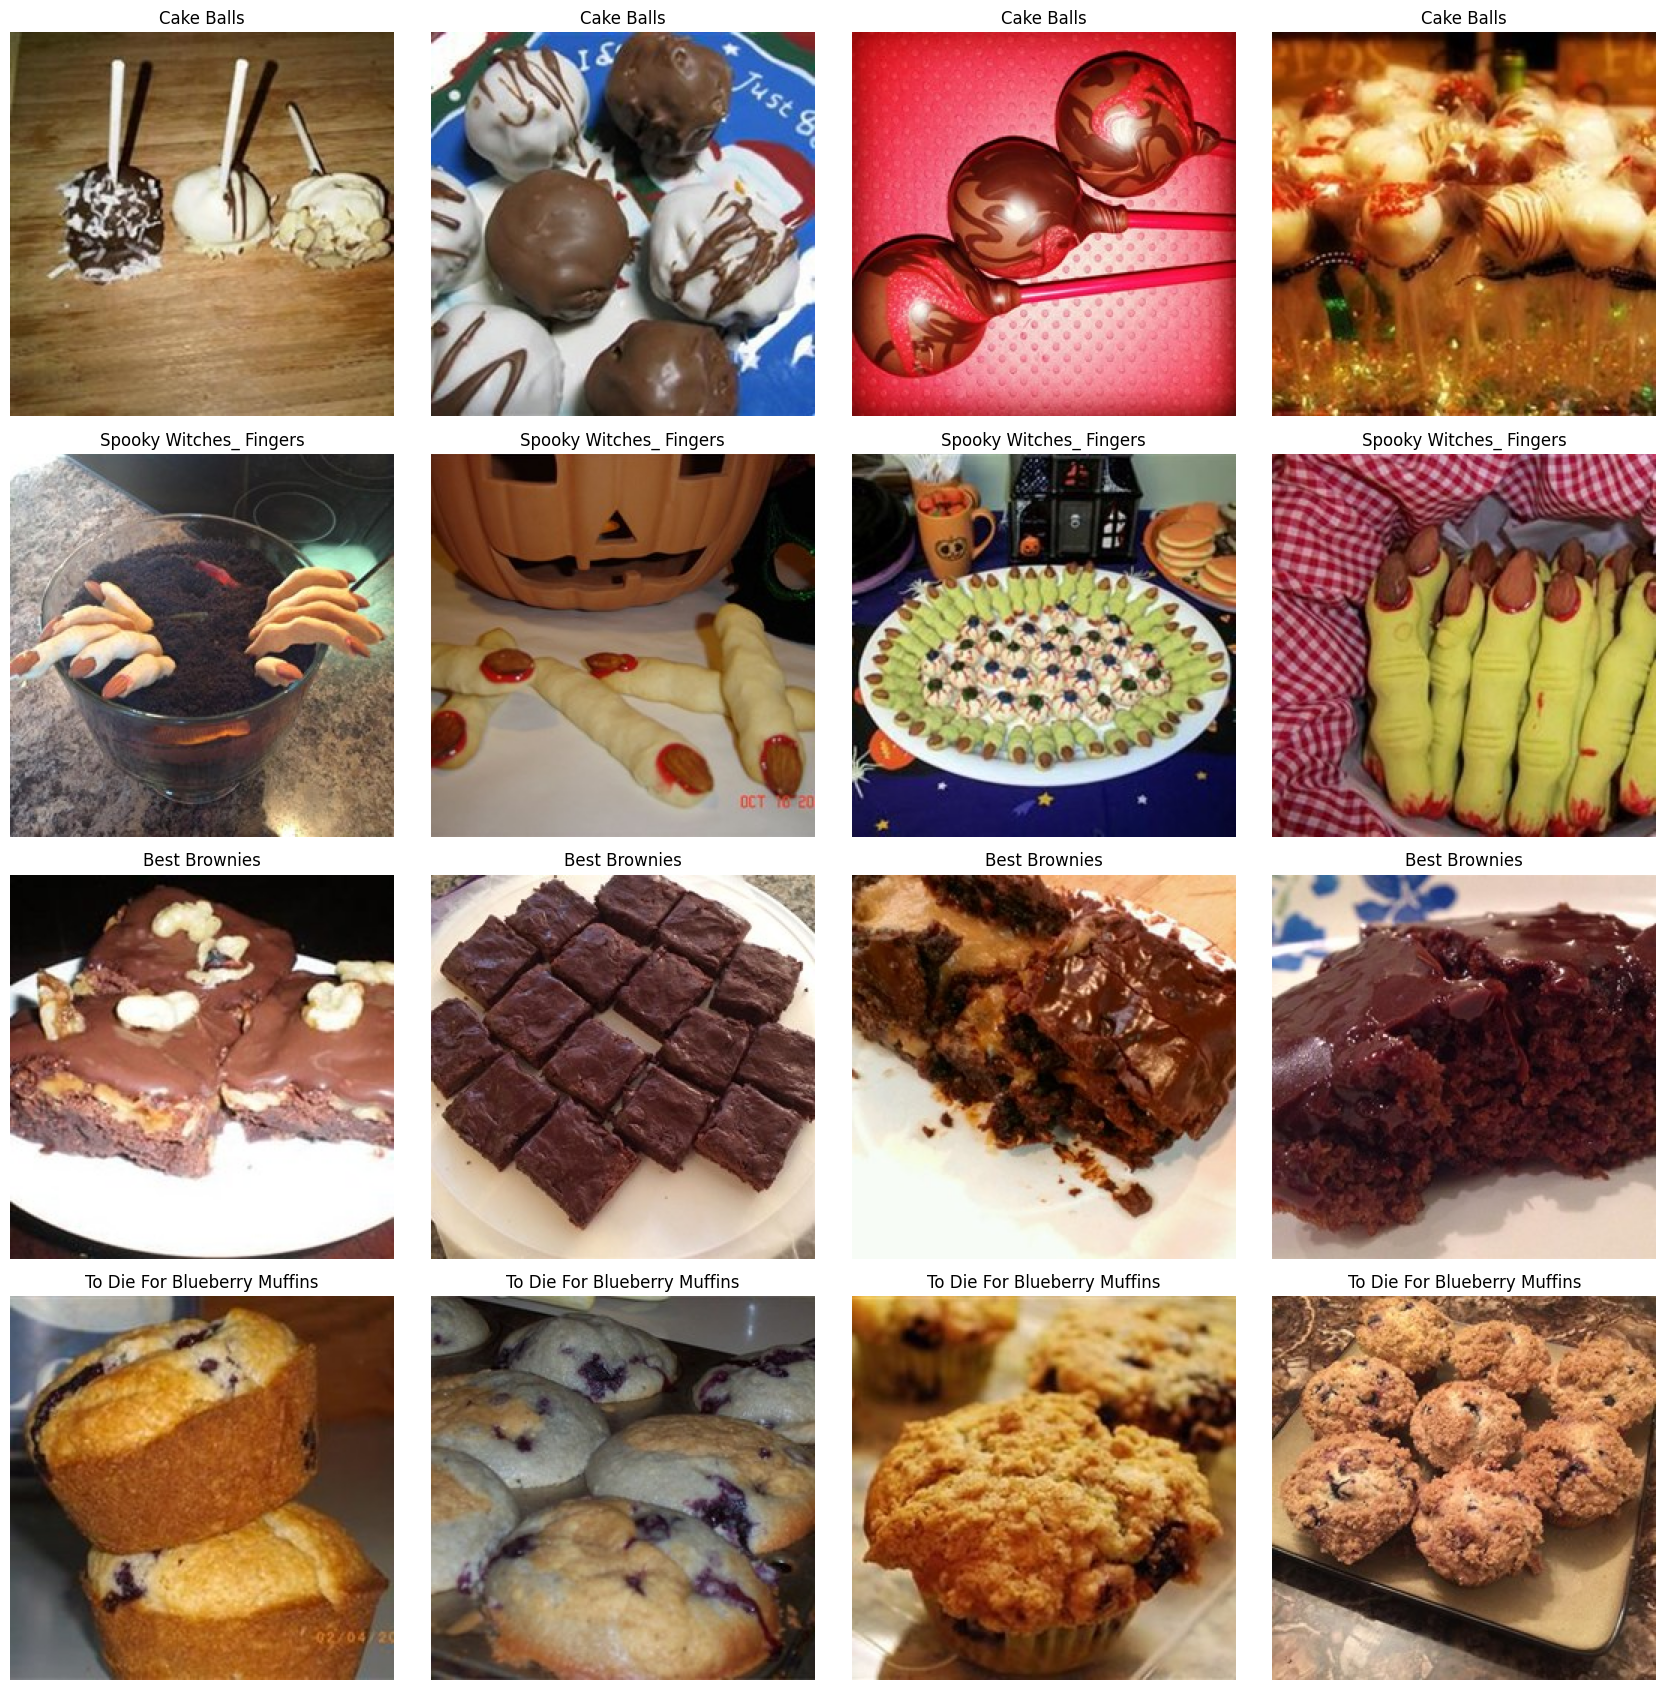

In [4]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import numpy as np

# Set the directory where your train dataset is located
train_dir = "/kaggle/input/traindataset/train_dataset"

# List classes/directories in the train dataset
classes = os.listdir(train_dir)
files_path_dict = {}

# For each class, list the images and create a full path to the images
for c in classes:
    class_dir = os.path.join(train_dir, c)
    files_path_dict[c] = [os.path.join(class_dir, x) for x in os.listdir(class_dir)]

plt.figure(figsize=(17, 17))
index = 0

# Adjust these variables to change the number of classes and images per class to display
num_classes_to_display = 4  # or len(classes) to display all
num_images_per_class = 4

# For each class, randomly select images and plot
for c in list(classes)[:num_classes_to_display]:
    random.shuffle(files_path_dict[c])
    path_list = files_path_dict[c][:num_images_per_class]

    for i in range(num_images_per_class):
        index += 1
        plt.subplot(num_classes_to_display, num_images_per_class, index)
        img = load_img(path_list[i])
        plt.imshow(img)
        plt.title(c)
        plt.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()


## Create a Function to Crop Images

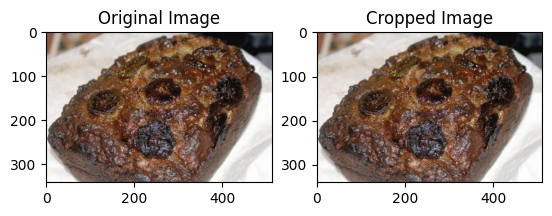

In [6]:
import cv2
import imutils
import matplotlib.pyplot as plt

# Your crop_image function as defined
def crop_image(image, plot=False):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

# Example usage
# Load an image
image_path = "/kaggle/input/traindataset/train_dataset/Banana Bread/00993016a6.jpg"  # Replace ClassName and imagename.jpg with actual values
image = cv2.imread(image_path)

# Crop the image
cropped_image = crop_image(image, plot=True)


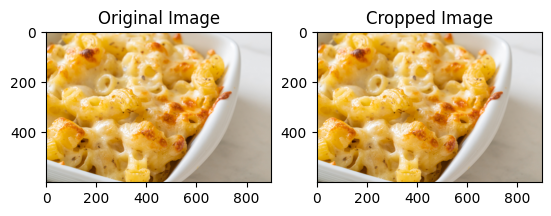

In [8]:
example_img = cv2.imread("/kaggle/input/val-dataset/val_dataset/Baked MAC and Cheese/Baked MAC and Cheese food dish_10.jpg")
cropped_img = crop_image(example_img,plot=True)

## Saving The Cropped Images 

In [9]:
import os

train_dir = "/kaggle/input/traindataset/train_dataset"
standardized_names = {}

for class_name in os.listdir(train_dir):
    standardized_name = class_name.replace(' ', '_').lower()
    if standardized_name in standardized_names:
        print(f"Potential duplicate: {class_name} -> {standardized_names[standardized_name]}")
    else:
        standardized_names[standardized_name] = class_name

print(f"Total unique standardized class names: {len(standardized_names)}")

Total unique standardized class names: 45


In [11]:
import os

val_dir = "/kaggle/input/val-dataset/val_dataset"
standardized_names = {}

for class_name in os.listdir(val_dir):
    standardized_name = class_name.replace(' ', '_').lower()
    if standardized_name in standardized_names:
        print(f"Potential duplicate: {class_name} -> {standardized_names[standardized_name]}")
    else:
        standardized_names[standardized_name] = class_name

print(f"Total unique standardized class names: {len(standardized_names)}")


Total unique standardized class names: 45


In [12]:
import os

test_dir = "/kaggle/input/test-dataset/test_dataset"
standardized_names = {}

for class_name in os.listdir(test_dir):
    standardized_name = class_name.replace(' ', '_').lower()
    if standardized_name in standardized_names:
        print(f"Potential duplicate: {class_name} -> {standardized_names[standardized_name]}")
    else:
        standardized_names[standardized_name] = class_name

print(f"Total unique standardized class names: {len(standardized_names)}")

Total unique standardized class names: 45


In [13]:
import os

def count_images_per_class(directory):
    # Check if the path exists
    if not os.path.exists(directory):
        print(f"The specified path does not exist: {directory}")
        return None
    
    # List all classes (directories) in the dataset
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print(f"Total classes found: {len(classes)}")
    
    # Initialize a dictionary to hold the count of images per class
    images_per_class = {}

    # Iterate over each class to count its images
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        image_count = len([img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))])
        images_per_class[class_name] = image_count

    # Print the count of images for each class
    for class_name, count in images_per_class.items():
        print(f"Class '{class_name}' has {count} images.")

    # Optionally, print the total number of images across all classes
    total_images = sum(images_per_class.values())
    print(f"Total images across all classes: {total_images}")

    return images_per_class



In [16]:
# Example usage:
#test_dir = "/kaggle/input/traindataset/train_dataset"
count_images_per_class(train_dir)

Total classes found: 45
Class 'Cake Balls' has 717 images.
Class 'Spooky Witches_ Fingers' has 330 images.
Class 'Best Brownies' has 428 images.
Class 'To Die For Blueberry Muffins' has 997 images.
Class 'Simple White Cake' has 349 images.
Class 'Peanut Butter Cup Cookies' has 388 images.
Class 'World_s Best Lasagna' has 651 images.
Class 'Easy Chicken with Broccoli' has 318 images.
Class 'Cajun Chicken Pasta' has 396 images.
Class 'Sweet, Sticky and Spicy Chicken' has 307 images.
Class 'Alfredo Sauce' has 300 images.
Class 'Cream Cheese Frosting' has 373 images.
Class 'Easy Sugar Cookies' has 433 images.
Class 'Soft Oatmeal Cookies' has 336 images.
Class 'Delicious Ham and Potato Soup' has 394 images.
Class 'Award Winning Soft Chocolate Chip Cookies' has 590 images.
Class 'Bread Pudding' has 331 images.
Class 'White Chocolate Raspberry Cheesecake' has 504 images.
Class 'The Best Rolled Sugar Cookies' has 1647 images.
Class 'Carrot Cake' has 606 images.
Class 'Bacon Wrapped Chicken Bre

{'Cake Balls': 717,
 'Spooky Witches_ Fingers': 330,
 'Best Brownies': 428,
 'To Die For Blueberry Muffins': 997,
 'Simple White Cake': 349,
 'Peanut Butter Cup Cookies': 388,
 'World_s Best Lasagna': 651,
 'Easy Chicken with Broccoli': 318,
 'Cajun Chicken Pasta': 396,
 'Sweet, Sticky and Spicy Chicken': 307,
 'Alfredo Sauce': 300,
 'Cream Cheese Frosting': 373,
 'Easy Sugar Cookies': 433,
 'Soft Oatmeal Cookies': 336,
 'Delicious Ham and Potato Soup': 394,
 'Award Winning Soft Chocolate Chip Cookies': 590,
 'Bread Pudding': 331,
 'White Chocolate Raspberry Cheesecake': 504,
 'The Best Rolled Sugar Cookies': 1647,
 'Carrot Cake': 606,
 'Bacon Wrapped Chicken Breast': 515,
 'Red Velvet Cupcakes': 307,
 'Ninety Minute Cinnamon Rolls': 334,
 'Special Buttercream Frosting': 364,
 'Good Old Fashioned Pancakes': 457,
 'Baked MAC and Cheese': 334,
 'Easy OREO Truffles': 342,
 'Big Soft Ginger Cookies': 349,
 'Chicken Cordon Bleu': 309,
 'Mom_s Zucchini Bread': 317,
 'Broiled Tilapia Parmesan

In [15]:
# Example usage:
#test_dir = "/kaggle/input/traindataset/train_dataset"
count_images_per_class(test_dir)

Total classes found: 45
Class 'Cake Balls' has 38 images.
Class 'Best Brownies' has 32 images.
Class 'To Die For Blueberry Muffins' has 38 images.
Class 'Simple White Cake' has 33 images.
Class 'Peanut Butter Cup Cookies' has 36 images.
Class 'World_s Best Lasagna' has 32 images.
Class 'Easy Chicken with Broccoli' has 34 images.
Class 'Cajun Chicken Pasta' has 199 images.
Class 'Alfredo Sauce' has 33 images.
Class 'Cream Cheese Frosting' has 40 images.
Class 'Easy Sugar Cookies' has 34 images.
Class 'Soft Oatmeal Cookies' has 33 images.
Class 'Delicious Ham and Potato Soup' has 35 images.
Class 'Award Winning Soft Chocolate Chip Cookies' has 31 images.
Class 'Bread Pudding' has 33 images.
Class 'White Chocolate Raspberry Cheesecake' has 33 images.
Class 'The Best Rolled Sugar Cookies' has 32 images.
Class 'Carrot Cake' has 36 images.
Class 'Bacon Wrapped Chicken Breast' has 33 images.
Class 'Red Velvet Cupcakes' has 48 images.
Class 'Ninety Minute Cinnamon Rolls' has 35 images.
Class '

{'Cake Balls': 38,
 'Best Brownies': 32,
 'To Die For Blueberry Muffins': 38,
 'Simple White Cake': 33,
 'Peanut Butter Cup Cookies': 36,
 'World_s Best Lasagna': 32,
 'Easy Chicken with Broccoli': 34,
 'Cajun Chicken Pasta': 199,
 'Alfredo Sauce': 33,
 'Cream Cheese Frosting': 40,
 'Easy Sugar Cookies': 34,
 'Soft Oatmeal Cookies': 33,
 'Delicious Ham and Potato Soup': 35,
 'Award Winning Soft Chocolate Chip Cookies': 31,
 'Bread Pudding': 33,
 'White Chocolate Raspberry Cheesecake': 33,
 'The Best Rolled Sugar Cookies': 32,
 'Carrot Cake': 36,
 'Bacon Wrapped Chicken Breast': 33,
 'Red Velvet Cupcakes': 48,
 'Ninety Minute Cinnamon Rolls': 35,
 'Special Buttercream Frosting': 40,
 'Good Old Fashioned Pancakes': 33,
 'Baked MAC and Cheese': 33,
 'Easy OREO Truffles': 34,
 'Big Soft Ginger Cookies': 28,
 'Chicken Cordon Bleu': 42,
 'Mom_s Zucchini Bread': 35,
 'Broiled Tilapia Parmesan': 40,
 'Parmesan Chicken Squares': 30,
 'Tiramisu Layer Cake': 37,
 'Rick_s Special Buttercream Frost

In [14]:

# Example usage:
val_dir = "/kaggle/input/val-dataset/val_dataset"
count_images_per_class(val_dir)

Total classes found: 45
Class 'Cake Balls' has 25 images.
Class 'Best Brownies' has 21 images.
Class 'To Die For Blueberry Muffins' has 26 images.
Class 'Simple White Cake' has 22 images.
Class 'Peanut Butter Cup Cookies' has 25 images.
Class 'World_s Best Lasagna' has 28 images.
Class 'Easy Chicken with Broccoli' has 23 images.
Class 'Cajun Chicken Pasta' has 34 images.
Class 'Alfredo Sauce' has 25 images.
Class 'Cream Cheese Frosting' has 27 images.
Class 'Easy Sugar Cookies' has 41 images.
Class 'Soft Oatmeal Cookies' has 23 images.
Class 'Delicious Ham and Potato Soup' has 24 images.
Class 'Award Winning Soft Chocolate Chip Cookies' has 22 images.
Class 'Bread Pudding' has 22 images.
Class 'White Chocolate Raspberry Cheesecake' has 26 images.
Class 'The Best Rolled Sugar Cookies' has 27 images.
Class 'Carrot Cake' has 25 images.
Class 'Bacon Wrapped Chicken Breast' has 23 images.
Class 'Red Velvet Cupcakes' has 149 images.
Class 'Ninety Minute Cinnamon Rolls' has 24 images.
Class '

{'Cake Balls': 25,
 'Best Brownies': 21,
 'To Die For Blueberry Muffins': 26,
 'Simple White Cake': 22,
 'Peanut Butter Cup Cookies': 25,
 'World_s Best Lasagna': 28,
 'Easy Chicken with Broccoli': 23,
 'Cajun Chicken Pasta': 34,
 'Alfredo Sauce': 25,
 'Cream Cheese Frosting': 27,
 'Easy Sugar Cookies': 41,
 'Soft Oatmeal Cookies': 23,
 'Delicious Ham and Potato Soup': 24,
 'Award Winning Soft Chocolate Chip Cookies': 22,
 'Bread Pudding': 22,
 'White Chocolate Raspberry Cheesecake': 26,
 'The Best Rolled Sugar Cookies': 27,
 'Carrot Cake': 25,
 'Bacon Wrapped Chicken Breast': 23,
 'Red Velvet Cupcakes': 149,
 'Ninety Minute Cinnamon Rolls': 24,
 'Special Buttercream Frosting': 28,
 'Good Old Fashioned Pancakes': 23,
 'Baked MAC and Cheese': 23,
 'Easy OREO Truffles': 23,
 'Big Soft Ginger Cookies': 20,
 'Chicken Cordon Bleu': 28,
 'Mom_s Zucchini Bread': 26,
 'Broiled Tilapia Parmesan': 25,
 'Parmesan Chicken Squares': 21,
 'Tiramisu Layer Cake': 26,
 'Rick_s Special Buttercream Frost

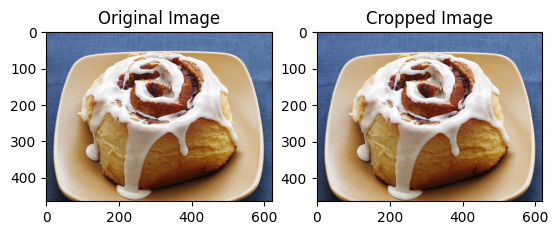

In [17]:
example_img = cv2.imread("/kaggle/input/test-dataset/test_dataset/Clone of a Cinnabon/Clone of a Cinnabon food dish_13.jpg")
cropped_img = crop_image(example_img,plot=True)

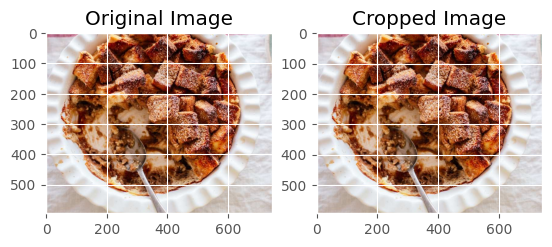

In [36]:


example_img = cv2.imread("/kaggle/input/test-dataset/test_dataset/Bread Pudding/Bread Pudding II food dish_10.jpg")
cropped_img = crop_image(example_img,plot=True)

## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generator for training data with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Initialize the data generator for validation data without augmentation
# Since you have a separate validation dataset, you don't need to use the `validation_split` parameter
val_datagen = ImageDataGenerator()

# For the test dataset, assuming you might want to apply the same preprocessing as validation
test_datagen = ImageDataGenerator()

# Configure the data generator for the training dataset
train_data = train_datagen.flow_from_directory(
    "/kaggle/input/traindataset/train_dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Configure the data generator for the validation dataset
val_data = val_datagen.flow_from_directory(
    "/kaggle/input/val-dataset/val_dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# For the test dataset, assuming you might want to apply the same preprocessing as validation
test_datagen = ImageDataGenerator()



# Configure the data generator for the validation dataset
test_data = test_datagen.flow_from_directory(
    "/kaggle/input/test-dataset/test_dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 23160 images belonging to 45 classes.
Found 1351 images belonging to 45 classes.
Found 1768 images belonging to 45 classes.


In [20]:
import os

train_dir = "/kaggle/input/traindataset/train_dataset"
val_dir = "/kaggle/input/val-dataset/val_dataset"
test_dir = "/kaggle/input/test-dataset/test_dataset"

# Function to count the number of images per class in a directory
def count_images_per_class(directory):
    classes = os.listdir(directory)
    images_per_class = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        num_images = len(os.listdir(class_path))
        images_per_class[class_name] = num_images
    return images_per_class

# Count images per class in each directory
train_images_per_class = count_images_per_class(train_dir)
val_images_per_class = count_images_per_class(val_dir)
test_images_per_class = count_images_per_class(test_dir)

# Print the results
print("Train Images per Class:")
print(train_images_per_class)
print()

print("Validation Images per Class:")
print(val_images_per_class)
print()

print("Test Images per Class:")
print(test_images_per_class)


Train Images per Class:
{'Cake Balls': 717, 'Spooky Witches_ Fingers': 330, 'Best Brownies': 428, 'To Die For Blueberry Muffins': 997, 'Simple White Cake': 349, 'Peanut Butter Cup Cookies': 388, 'World_s Best Lasagna': 651, 'Easy Chicken with Broccoli': 318, 'Cajun Chicken Pasta': 396, 'Sweet, Sticky and Spicy Chicken': 307, 'Alfredo Sauce': 300, 'Cream Cheese Frosting': 373, 'Easy Sugar Cookies': 433, 'Soft Oatmeal Cookies': 336, 'Delicious Ham and Potato Soup': 394, 'Award Winning Soft Chocolate Chip Cookies': 590, 'Bread Pudding': 331, 'White Chocolate Raspberry Cheesecake': 504, 'The Best Rolled Sugar Cookies': 1647, 'Carrot Cake': 606, 'Bacon Wrapped Chicken Breast': 515, 'Red Velvet Cupcakes': 307, 'Ninety Minute Cinnamon Rolls': 334, 'Special Buttercream Frosting': 364, 'Good Old Fashioned Pancakes': 457, 'Baked MAC and Cheese': 334, 'Easy OREO Truffles': 342, 'Big Soft Ginger Cookies': 349, 'Chicken Cordon Bleu': 309, 'Mom_s Zucchini Bread': 317, 'Broiled Tilapia Parmesan': 303

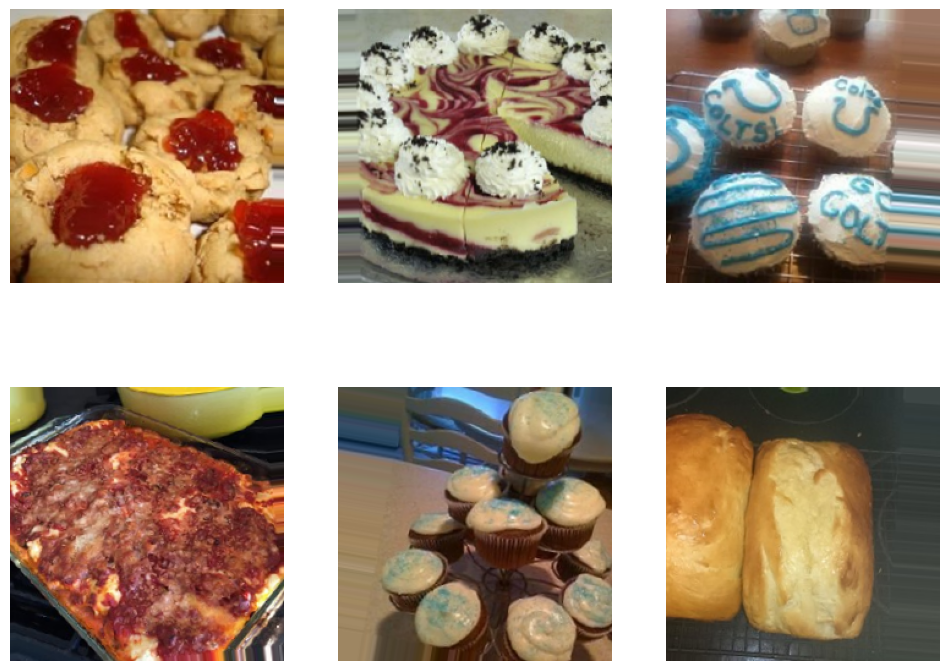

In [21]:
# View the augmented data.
sample_x,sample_y = next(train_data) 
plt.figure(figsize=(12,9))

for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model 

In [22]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet",include_top=False,input_shape=(224,224,3))

model = effnet.output

model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(45,activation='softmax')(model)
model = Model(inputs=effnet.input,outputs=model)

model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("efficientmodelB1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1) 

## Model Training and Model Evaluation

In [25]:
import os
os.environ['TF_DISABLE_GRAPPLER'] = 'true'

# Train the model
history = model.fit(train_data, epochs=7, validation_data=val_data, verbose=1, callbacks=[checkpoint, earlystop])




Epoch 1/7
1448/1448 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.7305
Epoch 1: val_accuracy improved from 0.50333 to 0.52184, saving model to efficientmodelB1.h5
1448/1448 [==============================] - 377s 260ms/step - loss: 0.8992 - accuracy: 0.7305 - val_loss: 1.8420 - val_accuracy: 0.5218
Epoch 2/7
1448/1448 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.7671
Epoch 2: val_accuracy improved from 0.52184 to 0.56995, saving model to efficientmodelB1.h5
1448/1448 [==============================] - 379s 261ms/step - loss: 0.7492 - accuracy: 0.7671 - val_loss: 1.7294 - val_accuracy: 0.5699
Epoch 3/7
1448/1448 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.7975
Epoch 3: val_accuracy improved from 0.56995 to 0.59363, saving model to efficientmodelB1.h5
1448/1448 [==============================] - 378s 261ms/step - loss: 0.6352 - accuracy: 0.7975 - val_loss: 1.5641 - val_accuracy: 0.5936
Epoch 4/7
1448/1448 [=

In [26]:
# Save the model in the native Keras format
model.save('efficientmodelB1.keras')

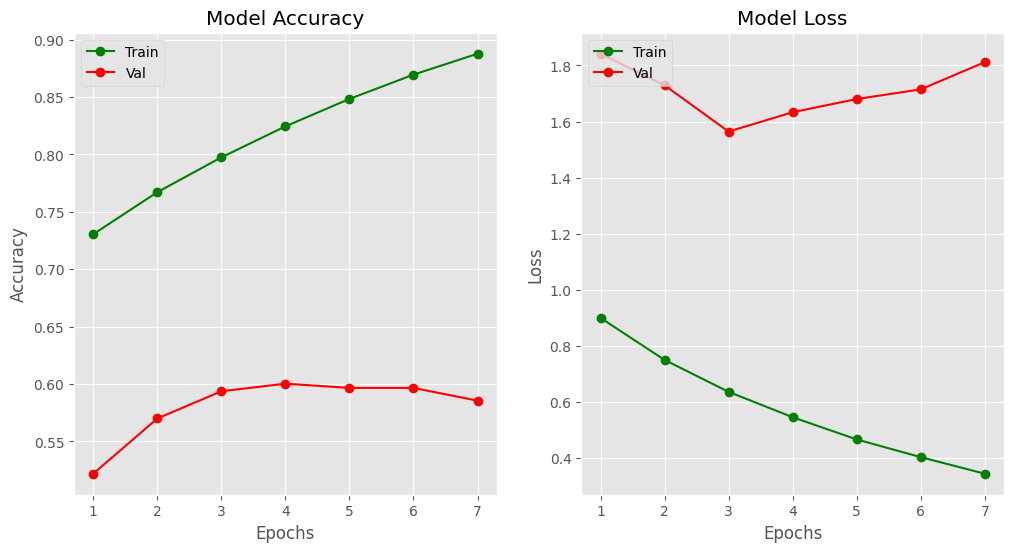

In [27]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"],loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Val"],loc="upper left")

In [28]:
# Evaluate the model on Test Set
model.evaluate(test_data)

  2/111 [..............................] - ETA: 51s - loss: 2.2240 - accuracy: 0.4688

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 [==============================] - 52s 467ms/step - loss: 1.9778 - accuracy: 0.5617


[1.977832555770874, 0.5616515874862671]

## Obtaining Predictions on Test Images

glioma_tumor


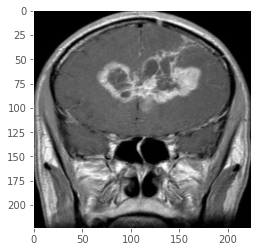

In [18]:
# Obtain Predictions on Test Images
class_dict = {0:'glioma_tumor',1:'meningioma_tumor',2:'no_tumor',3:'pituitary_tumor'}

test_img1 = cv2.imread("/content/Crop_Brain_MRI_Test/glioma_tumor/2.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1,axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

In [ ]:
from sklearn.metrics import classification_report

# For DenseNet121 model
# Predict probabilities for test data
y_pred_densenet = model.predict(D_test_data)

# Convert probabilities to class labels
y_pred_densenet = np.argmax(y_pred_densenet, axis=1)

# Get true labels
y_true_densenet = D_test_data.classes

# Generate classification report
print("Classification Report for DenseNet121:")
print(classification_report(y_true_densenet, y_pred_densenet))

# For UNet model
# Predict probabilities for test data
y_pred_unet = unet_model.predict(D_test_data)

# Convert probabilities to class labels
y_pred_unet = np.argmax(y_pred_unet, axis=1)

# Get true labels
y_true_unet = D_test_data.classes

# Generate classification report
print("Classification Report for UNet:")
print(classification_report(y_true_unet, y_pred_unet))


## Densenet Model

In [38]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generator for training data with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Initialize the data generator for validation data without augmentation
val_datagen = ImageDataGenerator()

# Initialize the data generator for test data
test_datagen = ImageDataGenerator()

# Configure the data generator for the training dataset
D_train_data = train_datagen.flow_from_directory(
    "/kaggle/input/traindataset/train_dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Configure the data generator for the validation dataset
D_val_data = val_datagen.flow_from_directory(
    "/kaggle/input/val-dataset/val_dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Configure the data generator for the test dataset
D_test_data = test_datagen.flow_from_directory(
    "/kaggle/input/test-dataset/test_dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)




Found 23160 images belonging to 45 classes.
Found 1351 images belonging to 45 classes.
Found 1768 images belonging to 45 classes.


In [39]:
# Build the DenseNet121 Model
densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [40]:
model = densenet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(45, activation='softmax')(model)
model = Model(inputs=densenet.input, outputs=model)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [41]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks (optional)
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)




In [42]:
# Train the model
history = model.fit(
    D_train_data,
    epochs=7,
    validation_data=D_val_data,
    verbose=1,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/7
1448/1448 [==============================] - ETA: 0s - loss: 1.8700 - accuracy: 0.5037
Epoch 1: val_accuracy improved from -inf to 0.36640, saving model to model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1448/1448 [==============================] - 453s 269ms/step - loss: 1.8700 - accuracy: 0.5037 - val_loss: 3.5709 - val_accuracy: 0.3664
Epoch 2/7
1448/1448 [==============================] - ETA: 0s - loss: 1.1400 - accuracy: 0.6715
Epoch 2: val_accuracy improved from 0.36640 to 0.40415, saving model to model.h5
1448/1448 [==============================] - 377s 260ms/step - loss: 1.1400 - accuracy: 0.6715 - val_loss: 2.7380 - val_accuracy: 0.4041
Epoch 3/7
1448/1448 [==============================] - ETA: 0s - loss: 0.9327 - accuracy: 0.7212
Epoch 3: val_accuracy did not improve from 0.40415
1448/1448 [==============================] - 373s 258ms/step - loss: 0.9327 - accuracy: 0.7212 - val_loss: 6.4859 - val_accuracy: 0.2946
Epoch 4/7
1448/1448 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.7500
Epoch 4: val_accuracy did not improve from 0.40415
1448/1448 [==============================] - 371s 256ms/step - loss: 0.8133 - accuracy: 0.7500 - val_loss: 5.0072 -

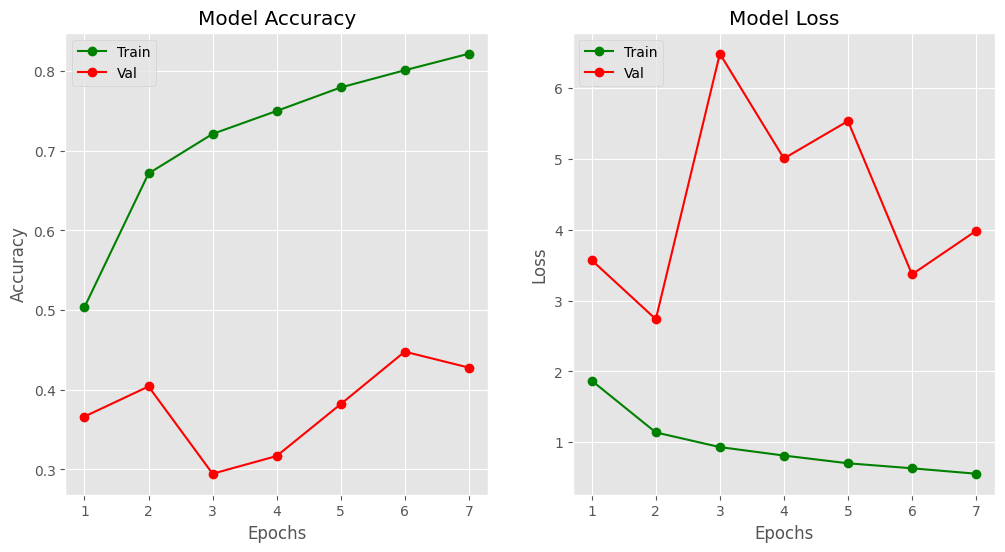

In [43]:
import matplotlib.pyplot as plt

# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
epochs = range(1, 8)

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc="upper left")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc="upper left")

plt.show()


In [44]:
# Evaluate the model on Test Set
model.evaluate(D_test_data)

 44/111 [==========>...................] - ETA: 22s - loss: 4.4817 - accuracy: 0.3622

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 [==============================] - 36s 318ms/step - loss: 4.4639 - accuracy: 0.3756


[4.463859558105469, 0.37556561827659607]

In [ ]:
from sklearn.metrics import classification_report

# For DenseNet121 model
# Predict probabilities for test data
y_pred_densenet = model.predict(D_test_data)

# Convert probabilities to class labels
y_pred_densenet = np.argmax(y_pred_densenet, axis=1)

# Get true labels
y_true_densenet = D_test_data.classes

# Generate classification report
print("Classification Report for DenseNet121:")
print(classification_report(y_true_densenet, y_pred_densenet))

# For UNet model
# Predict probabilities for test data
y_pred_unet = unet_model.predict(D_test_data)

# Convert probabilities to class labels
y_pred_unet = np.argmax(y_pred_unet, axis=1)

# Get true labels
y_true_unet = D_test_data.classes

# Generate classification report
print("Classification Report for UNet:")
print(classification_report(y_true_unet, y_pred_unet))


## UNET Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

def unet_model(input_shape=(224, 224, 3), num_classes=45):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    # Define model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create the UNet model
unet_model = unet_model()

# Compile the model
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
unet_model.summary()
